In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# from fastai.imports import *
import os
import pandas as pd
from pandas.api.types import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import 

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
df = pd.read_csv('Train.csv', low_memory=False, parse_dates=['saledate'])

In [4]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.tail().transpose()

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [6]:
# cols = df.columns.values
# for col in cols:
#     print("{} = {}".format(col, df[col].isnull().value_counts()))

In [7]:
df.SalePrice = np.log(df.SalePrice)

In [8]:
import re
def add_datepart(df, fldname):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
             'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace=True)
    

In [9]:
add_datepart(df, 'saledate')

In [10]:
def apply_cats(df,trn):
    for n,c in df.items():
        if trn[n].dtype.name == 'category':
            df[n] = pd.Categorical(c,categories=trn[n].cat.categories, oredered=True)

In [11]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype('category').cat.as_ordered()

In [12]:
train_cats(df)

In [13]:
df.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [14]:
df.UsageBand.cat.set_categories(['High', 'Low', 'Medium'], ordered=True, inplace=True)

In [15]:
df.isnull().sum().sort_index()/len(df)

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [16]:
def fix_missing(df, col, name):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum():
            df[name+'_na'] = pd.isnull(col)
        df[name] = col.fillna(col.median())
#     return (df)

In [17]:
def numericalize(df, col, name, max_n_cat=None):
    if not is_numeric_dtype(col) and (max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1
#     return (df)
            


In [18]:
from sklearn.preprocessing import StandardScaler
def scale_vars(df):
    map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
    mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

In [19]:
def proc_df(df, y_fld, skip_flds=None, do_scale=False,
           preproc_fn=None, max_n_cat=None, subset=None):
    if not skip_flds: skip_flds=[]
#     if subset: df = get_sample(df, subset)
    df = df.copy()
#     if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)
    
    for n,c in df.items(): fix_missing(df, c, n)
    if do_scale: mapper = scale_vars(df)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y]
    if not do_scale: return res
    return res + [mapper]
    

In [20]:
# for n,c in df.items():
#     df_new = fix_missing(df, c, n)

In [21]:
# for n,c in df.items():
#     df_new = numericalize(df, c, n)
    

In [22]:
df_new, y = proc_df(df, 'SalePrice')

In [23]:
df_new.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,2,950,296,...,320,False,False,False,False,False,False,6512,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1725,527,...,86,False,False,False,False,False,False,5547,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,...,57,False,False,False,False,False,False,5518,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,...,139,False,False,False,False,False,False,8157,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,3,4208,1529,...,204,False,False,False,False,False,False,7492,False,False


In [24]:
# X = df_new.drop('SalePrice', axis=1)
# y = df_new.SalePrice

In [25]:
rf = RandomForestRegressor(n_jobs=-1)

In [26]:
%%time
rf.fit(df_new, y)

CPU times: user 1min 9s, sys: 449 ms, total: 1min 9s
Wall time: 13.6 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [27]:
rf.score(df_new, y)

0.9831264410413523

In [28]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

In [29]:
n_valid = 12000
n_trn = len(df_new) - n_valid
df_train, df_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df_new, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [30]:
import math
def rmse(x, y): return math.sqrt(((x-y)**2).mean())

In [31]:
def print_score(m):
    res  = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [32]:
rf1 = RandomForestRegressor(n_jobs=-1)
%time rf1.fit(X_train, y_train)
print_score(rf1)

CPU times: user 1min 8s, sys: 493 ms, total: 1min 9s
Wall time: 14 s
[0.09047465807020719, 0.25069812748615317, 0.9828924141918365, 0.8877593548631892]


In [33]:
df_trn, y_trn = proc_df(df, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)
X_train.shape, y_train.shape, _.shape

((20000, 66), (20000,), (381125,))

In [34]:
rf2 = RandomForestRegressor(n_jobs=-1)
%time rf2.fit(X_train, y_train)
print_score(rf2)

CPU times: user 2.76 s, sys: 32.3 ms, total: 2.79 s
Wall time: 700 ms
[0.10415231556417515, 0.3333344708003962, 0.9780708048390867, 0.8015694991732601]


In [35]:
single_tree_rf3 = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
%time single_tree_rf3.fit(X_train, y_train)
print_score(single_tree_rf3)

CPU times: user 118 ms, sys: 10.6 ms, total: 129 ms
Wall time: 177 ms
[0.4965829795739235, 0.5246832258551849, 0.5014961773561586, 0.5083655198087847]


In [36]:
no_depth_single_tree_rf4 = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
%time no_depth_single_tree_rf4.fit(X_train, y_train)
print_score(no_depth_single_tree_rf4)

CPU times: user 364 ms, sys: 9.48 ms, total: 373 ms
Wall time: 381 ms
[8.331852114593072e-17, 0.4619736253490039, 1.0, 0.618861923666805]


In [37]:
rf5 = RandomForestRegressor(n_jobs=-1)
%time rf5.fit(X_train, y_train)
print_score(rf5)

CPU times: user 2.72 s, sys: 21.9 ms, total: 2.75 s
Wall time: 589 ms
[0.10459099346784292, 0.3390166946311929, 0.9778856891806728, 0.794746701806234]


In [40]:
preds = np.stack([t.predict(X_valid) for t in rf5.estimators_]) 
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.04782144, 9.21034037, 8.98719682, 9.04782144, 9.21034037,
        9.04782144, 9.04782144, 9.04782144, 9.39266193, 9.04782144]),
 9.108746814825492,
 9.104979856318357)

In [41]:
preds.shape

(10, 12000)

In [43]:
from sklearn import metrics

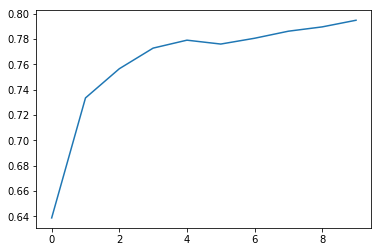

In [44]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

In [45]:
rf5 = RandomForestRegressor(n_estimators=80, n_jobs=-1)
rf5.fit(X_train, y_train)
print_score(rf5)

[0.08711918392023078, 0.32332997852598944, 0.9846569242191069, 0.8133018902832081]


In [46]:
df_trn, y_trn = proc_df(df, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [47]:
rf6 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                      max_features=0.5, n_jobs=-1, oob_score=True) 
rf6.fit(X_train, y_train) 
print_score(rf6)

[0.11902198155022135, 0.22899374509588663, 0.9703933561883498, 0.906352710087773, 0.911719434020048]


In [ ]:
df_test = pd.read_csv('Test.csv', low_memory=False, parse_dates=['saledate'])

In [ ]:
add_datepart(df_test, 'saledate')

In [ ]:
for n,c in df_test.items():
    fix_missing(df_test, c, n)

In [ ]:
df_test.head()

In [ ]:
for n,c in df_test.items():
    numericalize(df_test, c, n)

In [ ]:
prediction = rf.predict(df_test)

In [ ]:
PATH_TO_DATA = '/Users/tejaswinalwad/Machine_Learning/Kaggle_Projects/Blue\ Book\ for\ Bulldozers'

In [ ]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['SalesID'] = df_test['SalesID']
    submission['SalePrice'] = prediction
    submission.to_csv(filename)